In [2]:
from acm.hod import AbacusHOD
from acm.utils import setup_logging
import numpy as np
from pathlib import Path
import pandas

setup_logging()

def get_hod_params(nrows=None):
    """Some example HOD parameters."""
    hod_dir = Path(f'/pscratch/sd/e/epaillas/emc/hod_params/yuan23/')
    hod_fn = hod_dir / f'hod_params_yuan23_c000.csv'
    df = pandas.read_csv(hod_fn, delimiter=',')
    df.columns = df.columns.str.strip()
    df.columns = list(df.columns.str.strip('# ').values)
    return df.to_dict('list')


# read example HOD parameters
hod_params = get_hod_params()

# load abacusHOD class
abacus = AbacusHOD(varied_params=hod_params.keys(),
                   sim_type='small', redshift=0.5,
                   cosmo_idx=0, phase_idx=3000)

Loading simulation by slab,  0
[000002.82]  04-16 08:33  AbacusHOD                    INFO     Processing AbacusSummit_small_c000_ph3000 at z = 0.5
[000002.82]  04-16 08:33  AbacusHOD                    INFO     Varied parameters: ['logM_cut', 'logM1', 'sigma', 'alpha', 'kappa', 'alpha_c', 'alpha_s', 's', 'Acent', 'Asat', 'Bcent', 'Bsat'].
[000002.82]  04-16 08:33  AbacusHOD                    INFO     Default parameters: {'s_v': 0, 's_p': 0, 's_r': 0, 'ic': 1.0}.


### Sample the first 10 HODs from our list

In [6]:
hod_positions = []
for i in range(10):
    hod = {key: hod_params[key][i] for key in hod_params.keys()}
    positions_dict = abacus.run(hod, nthreads=16)
    pos = np.c_[positions_dict['X'], positions_dict['Y'], positions_dict['Z_RSD']]
    hod_positions.append(pos)

gen mocks 0.011687278747558594
gen mocks 0.01477670669555664
gen mocks 0.015764236450195312
gen mocks 0.016295194625854492
gen mocks 0.016719818115234375
gen mocks 0.012908220291137695
gen mocks 0.011115789413452148
gen mocks 0.01445770263671875
gen mocks 0.011716365814208984
gen mocks 0.013062000274658203


### Let's have a look at the clustering to ensure everything is sensible

[000622.24]  04-16 08:43  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000622.24]  04-16 08:43  TwoPointCorrelationFunction  INFO     Running auto-correlation.
[000622.24]  04-16 08:43  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000622.27]  04-16 08:43  TwoPointCorrelationFunction  INFO     Analytically computing two-point counts R1R2.
[000622.27]  04-16 08:43  TwoPointCorrelationFunction  INFO     Correlation function computed in elapsed time 0.03 s.
[000622.27]  04-16 08:43  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000622.27]  04-16 08:43  TwoPointCorrelationFunction  INFO     Running auto-correlation.
[000622.27]  04-16 08:43  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000622.47]  04-16 08:43  TwoPointCorrelationFunction  INFO     Analytically computing two-point counts R1R2.
[000

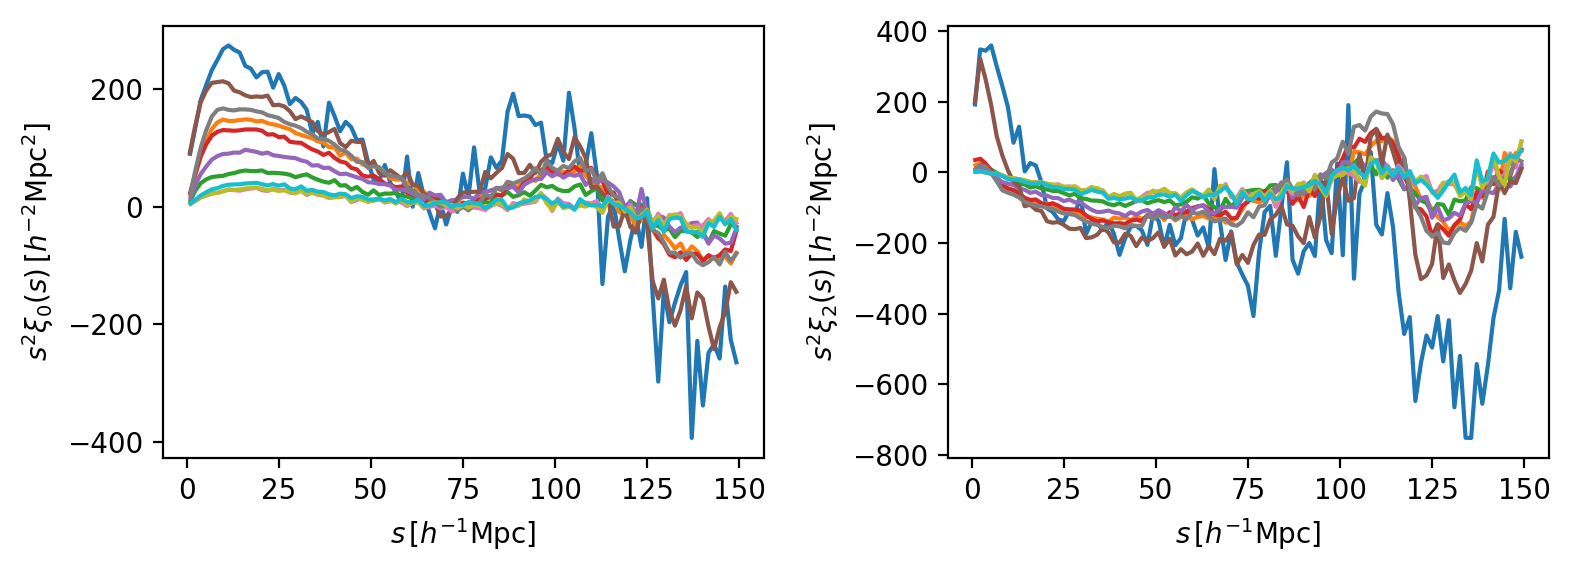

In [15]:
from pycorr import TwoPointCorrelationFunction
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

sedges = np.linspace(0, 150, 100)
muedges = np.linspace(-1, 1, 241)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

for i in range(10):
    pos = hod_positions[i]
    result = TwoPointCorrelationFunction(data_positions1=pos, boxsize=abacus.boxsize,
                                        mode='smu', edges=(sedges, muedges), los='z',
                                        nthreads=16, position_type='pos')
    s, multipoles = result(ells=(0, 2, 4), return_sep=True)
    ax[0].plot(s, s**2*multipoles[0])
    ax[1].plot(s, s**2*multipoles[1])
    
ax[0].set_xlabel(r'$s\, [h^{-1}{\rm Mpc}]$')
ax[1].set_xlabel(r'$s\, [h^{-1}{\rm Mpc}]$')
ax[0].set_ylabel(r'$s^2 \xi_0(s)\,[h^{-2}{\rm Mpc^2}]$')
ax[1].set_ylabel(r'$s^2 \xi_2(s)\,[h^{-2}{\rm Mpc^2}]$')
plt.tight_layout()
plt.show()